In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings("ignore") 

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic com Árvore de Decisão 

Datasets utilizados 

In [2]:
#csv dataset de treinamento
train_ = '../input/titanic/train.csv'
#csv dataset para teste
test_ = '../input/titanic/test.csv'
#csv do exemplo de dataset para submissão
submission_ = '../input/titanic/gender_submission.csv'

In [3]:
#df treino
train_df = pd.read_csv(train_)
#df teste
test_df = pd.read_csv(test_)
#df submissão
submission_df = pd.read_csv(submission_)

In [4]:
submission_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Adição de colunas

Nesta seção foi adicionado aos datasets as colunas 'Family_Size' e 'Size Family'

[Material de referência](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)

In [7]:
train_df['Family_Size'] = train_df['SibSp']+train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp']+test_df['Parch'] + 1

In [8]:
i = 0
train_df['Size_Family'] = train_df['Family_Size']
for fam in train_df['Family_Size']:
    if fam == 1:
        #print('Sozinho', fam)
        train_df['Size_Family'][i] = 'singleton' 
    elif 5 > fam > 1:
        #print('Pequena', fam)
        train_df['Size_Family'][i] = 'small'
    elif 5 <= fam:
        #print('Grande',fam)
        train_df['Size_Family'][i] = 'large'
    i += 1 

## Análise Exploratória

In [9]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Size_Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,singleton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,singleton


In [10]:
#Correlação entre colunas e survived
train_df.corr()[['Survived']].sort_values(by='Survived', ascending=False)

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
Family_Size,0.016639
PassengerId,-0.005007
SibSp,-0.035322
Age,-0.077221
Pclass,-0.338481


In [11]:
# taxa de sobreviventes por classe
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


* Classe 1 tem uma taxa de sobrevivência superior as demais. 

In [12]:
# taxa de sobreviventes por sexo
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


* Mulheres têm uma taxa de sobrevivência bem superior aos homens.

In [13]:
# taxa de sobrevivente por sexo e classe
train_df[["Sex", "Survived",'Pclass']].groupby(['Sex','Pclass']).mean().sort_values(by='Survived', ascending=False)

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

* Em ambos os sexos a taxa da classe 1 é maior, apesar das mulheres de classe 1 e 2 terem uma taxa bem semelhante. Vale também destacar a diferença entre as mulheres de classe 3 com as demais.  

In [14]:
# taxa de sobrevivente por embarque
train_df[["Embarked", "Survived"]].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


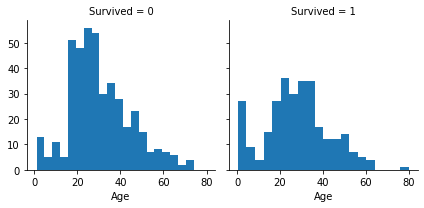

In [15]:
#Número de sobreviventes ou não por idade
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

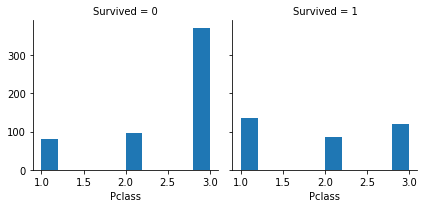

In [16]:
#Número de sobreviventes por classe
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Pclass')

In [17]:
# Tamanho Família
train_df[["Size_Family", "Survived"]].groupby(['Size_Family']).mean().sort_values(by='Size_Family', ascending=False)

,Survived
Size_Family,
small,0.578767
singleton,0.303538
large,0.161290


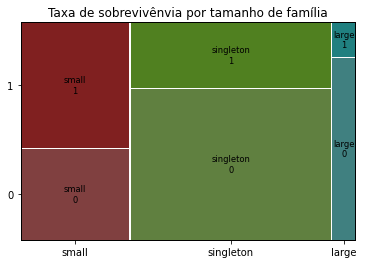

In [18]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train_df, ['Size_Family','Survived'], title = 'Taxa de sobrevivênvia por tamanho de família')
plt.show()

## Tranformar dataset para poder treinar o modelo

### Train_df

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Family_Size  891 non-null    int64  
 13  Size_Family  891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


Com o info é possível observar:
* Coluna Age com dados nulos
* Coluna Cabin com dados nulos
* Coluna Embarked com dados nulos

In [20]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000


In [21]:
# Trocar dados nulos por 1000 na coluna Age
train_df['Age'] = train_df['Age'].replace(np.nan, 1000)

In [22]:
# Média coluna Age
mean_age_train = train_df['Age'].mean()
#Trocar 1000 pela média da coluna
train_df['Age'] = train_df['Age'].replace(1000, mean_age_train)
#Ver os dados da coluna
train_df['Age'].unique()

array([ 22.        ,  38.        ,  26.        ,  35.        ,
       222.45249158,  54.        ,   2.        ,  27.        ,
        14.        ,   4.        ,  58.        ,  20.        ,
        39.        ,  55.        ,  31.        ,  34.        ,
        15.        ,  28.        ,   8.        ,  19.        ,
        40.        ,  66.        ,  42.        ,  21.        ,
        18.        ,   3.        ,   7.        ,  49.        ,
        29.        ,  65.        ,  28.5       ,   5.        ,
        11.        ,  45.        ,  17.        ,  32.        ,
        16.        ,  25.        ,   0.83      ,  30.        ,
        33.        ,  23.        ,  24.        ,  46.        ,
        59.        ,  71.        ,  37.        ,  47.        ,
        14.5       ,  70.5       ,  32.5       ,  12.        ,
         9.        ,  36.5       ,  51.        ,  55.5       ,
        40.5       ,  44.        ,   1.        ,  61.        ,
        56.        ,  50.        ,  36.        ,  45.5 

* Observe que não há dados '1000' nem nulos

In [23]:
#train_df[["Embarked","Survived"]].groupby(['Embarked']).count()
# Trocando Dados nulos pelo 'S'
train_df['Embarked'] = train_df['Embarked'].replace(np.nan, 'S')

In [24]:
train_df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Family_Size  891 non-null    int64  
 13  Size_Family  891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


In [26]:
#Dados de treino sem as colunas 'Cabin', 'Name', 'PassengerId'
train_df = train_df[['Pclass','Sex','SibSp','Age','Parch','Fare','Embarked','Survived','Family_Size']]

In [27]:
train_df.head()

,Pclass,Sex,SibSp,Age,Parch,Fare,Embarked,Survived,Family_Size
0,3,male,1,22.0,0,7.2500,S,0,2
1,1,female,1,38.0,0,71.2833,C,1,2
2,3,female,0,26.0,0,7.9250,S,1,1
3,1,female,1,35.0,0,53.1000,S,1,2
4,3,male,0,35.0,0,8.0500,S,0,1


In [28]:
#Tranformar colunas 'Sex', 'Embarked' e 'Title' em numéricas
train_df['Sex'], Sex_train = train_df['Sex'].factorize()
train_df['Embarked'], Embarked_train = train_df['Embarked'].factorize()

In [29]:
#train_df final
train_df.head()

,Pclass,Sex,SibSp,Age,Parch,Fare,Embarked,Survived,Family_Size
0,3,0,1,22.0,0,7.2500,0,0,2
1,1,1,1,38.0,0,71.2833,1,1,2
2,3,1,0,26.0,0,7.9250,0,1,1
3,1,1,1,35.0,0,53.1000,0,1,2
4,3,0,0,35.0,0,8.0500,0,0,1


In [30]:
train_df.corr()[['Survived']]

,Survived
Pclass,-0.338481
Sex,0.543351
SibSp,-0.035322
Age,-0.102539
Parch,0.081629
Fare,0.257307
Embarked,0.106811
Survived,1.000000
Family_Size,0.016639


### test_df

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Family_Size  418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


Com o info é possível observar:

* Coluna Age com dados nulos
* Coluna Cabin com dados nulos
* Coluna Fare com dados nulos

In [32]:
# Trocar dados nulos da coluna Fare por 1000
test_df['Fare'] = test_df['Fare'].replace(np.nan, 1000)

In [33]:
#média coluna Fare
mean_fare_test = test_df['Fare'].mean()
#Substituir '1000' pela média
test_df['Fare'] = test_df['Fare'].replace(1000, mean_fare_test)
test_df['Fare'].unique()

array([  7.8292    ,   7.        ,   9.6875    ,   8.6625    ,
        12.2875    ,   9.225     ,   7.6292    ,  29.        ,
         7.2292    ,  24.15      ,   7.8958    ,  26.        ,
        82.2667    ,  61.175     ,  27.7208    ,  12.35      ,
         7.225     ,   7.925     ,  59.4       ,   3.1708    ,
        31.6833    ,  61.3792    , 262.375     ,  14.5       ,
        61.9792    ,  30.5       ,  21.6792    ,  31.5       ,
        20.575     ,  23.45      ,  57.75      ,   8.05      ,
         9.5       ,  56.4958    ,  13.4167    ,  26.55      ,
         7.85      ,  13.        ,  52.5542    ,  29.7       ,
         7.75      ,  76.2917    ,  15.9       ,  60.        ,
        15.0333    ,  23.        , 263.        ,  15.5792    ,
        29.125     ,   7.65      ,  16.1       ,  13.5       ,
         7.725     ,  21.        ,   7.8792    ,  42.4       ,
        28.5375    , 211.5       ,  25.7       ,  15.2458    ,
       221.7792    ,  10.7083    ,  14.4542    ,  13.9 

In [34]:
# Trocar dados nulos da coluna Age por 1000
test_df['Age'] = test_df['Age'].replace(np.nan, 1000)

In [35]:
#média coluna Age
mean_age_test = test_df['Age'].mean()
#Substituir '1000' pela média
test_df['Age'] = test_df['Age'].replace(1000, mean_age_test)
test_df['Age'].unique()

array([3.45000000e+01, 4.70000000e+01, 6.20000000e+01, 2.70000000e+01,
       2.20000000e+01, 1.40000000e+01, 3.00000000e+01, 2.60000000e+01,
       1.80000000e+01, 2.10000000e+01, 2.29785885e+02, 4.60000000e+01,
       2.30000000e+01, 6.30000000e+01, 2.40000000e+01, 3.50000000e+01,
       4.50000000e+01, 5.50000000e+01, 9.00000000e+00, 4.80000000e+01,
       5.00000000e+01, 2.25000000e+01, 4.10000000e+01, 3.30000000e+01,
       1.85000000e+01, 2.50000000e+01, 3.90000000e+01, 6.00000000e+01,
       3.60000000e+01, 2.00000000e+01, 2.80000000e+01, 1.00000000e+01,
       1.70000000e+01, 3.20000000e+01, 1.30000000e+01, 3.10000000e+01,
       2.90000000e+01, 2.85000000e+01, 3.25000000e+01, 6.00000000e+00,
       6.70000000e+01, 4.90000000e+01, 2.00000000e+00, 7.60000000e+01,
       4.30000000e+01, 1.60000000e+01, 1.00000000e+00, 1.20000000e+01,
       4.20000000e+01, 5.30000000e+01, 2.65000000e+01, 4.00000000e+01,
       6.10000000e+01, 6.05000000e+01, 7.00000000e+00, 1.50000000e+01,
      

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Family_Size  418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [37]:
#Dados de teste sem as colunas 'Cabin', 'Name' e 'PassengerId'
test_df = test_df[['Pclass','Sex','SibSp','Age','Parch','Fare','Embarked','Family_Size']]
test_df.head()

,Pclass,Sex,SibSp,Age,Parch,Fare,Embarked,Family_Size
0,3,male,0,34.5,0,7.8292,Q,1
1,3,female,1,47.0,0,7.0000,S,2
2,2,male,0,62.0,0,9.6875,Q,1
3,3,male,0,27.0,0,8.6625,S,1
4,3,female,1,22.0,1,12.2875,S,3


In [38]:
#Transformando colunas 'Sex' e 'Embarked' em numéricas
test_df['Sex'], Sex_test = test_df['Sex'].factorize()
test_df['Embarked'], Embarked_test = test_df['Embarked'].factorize()

In [39]:
#test_df final
test_df.head()

,Pclass,Sex,SibSp,Age,Parch,Fare,Embarked,Family_Size
0,3,0,0,34.5,0,7.8292,0,1
1,3,1,1,47.0,0,7.0000,1,2
2,2,0,0,62.0,0,9.6875,0,1
3,3,0,0,27.0,0,8.6625,1,1
4,3,1,1,22.0,1,12.2875,1,3


## Modelo

Divisão das features e target.

In [40]:
#features
X = train_df.drop('Survived',axis = 1)
#target
y = train_df['Survived']

Divisão dos dados de treinamento e teste, 70% treino e 30 % teste.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [42]:
#X final para submissão da competição
X_test_final = test_df

In [43]:
#Random Forest
RF = RandomForestClassifier(random_state = 1)

Método grid, para achar os melhores parâmetros paro o modelo.

In [44]:
# Parâmetros testados
rf_params = {'random_state': [1],
             'max_depth': [7, 8, 9, 10, 11, 12],
             'max_features': [1,3,6],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100,300]}

#Grid
grid = GridSearchCV(RF, 
                    rf_params,
                    cv = 10,   
                    n_jobs = -1)

grid.fit(X_train, y_train)

#Parâmetros do melhor modelo
grid.best_params_

{'max_depth': 11,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100,
 'random_state': 1}

In [45]:
#melhor modelo
model = RandomForestClassifier(**grid.best_params_)

In [46]:
#treino
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features=1, min_samples_split=5,
                       random_state=1)

In [47]:
#score
model.score(X_test,y_test)

0.7873134328358209

In [48]:
#Validação Cruzada
scores = cross_val_score(model, X, y, cv=10)
scores.mean()

0.818289637952559

In [49]:
#Predição para submissão
tree_pred = model.predict(X_test_final)

In [50]:
#Submissão csv
sub_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
sub_df['PassengerId'] = submission_df['PassengerId']
sub_df['Survived'] = tree_pred
sub_df.to_csv('submission.csv', header=True, index=False)
sub_df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0
